# Pricing Barrier Call Options using Monte Carlo Simulation

This notebook prices a **barrier option**, a class of **path-dependent exotic options**, using the Monte Carlo method.

Barrier options are widely used in structured products and risk management due to their cost-effectiveness compared to vanilla options.

In [1]:
import numpy as np

In [2]:
# Simulate GBM paths for Barrier Options

def simulate_barrier_path(S0, r, T, sigma, M, N):
    dt = T / M
    S_paths = np.zeros((N, M+1))
    S_paths[:, 0] = S0

    for t in range(1, M+1):
        Z = np.random.randn(N)

        S_paths[:, t] = S_paths[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + (sigma * np.sqrt(dt) * Z))

    return S_paths

In [3]:
# Down-and-Out Call Option
def down_and_out_call(S_paths, K, r, T, B1):
    S_T = S_paths[:,-1]
    knocked_out = np.any(S_paths <= B1, axis=1)
    down_out_payoffs = np.exp(-r*T) * np.where(~knocked_out, np.maximum(S_T - K, 0), 0)

    return np.mean(down_out_payoffs), down_out_payoffs

In [4]:
# Up and Out Call Option
def up_and_out_call(S_paths, K, r, T, B2):
    S_T = S_paths[:, -1]
    knocked_out = np.any(S_paths >= B2, axis = 1)
    up_out_payoffs = np.exp(-r*T) * np.where(~knocked_out, np.maximum(S_T - K, 0), 0)

    return np.mean(up_out_payoffs), up_out_payoffs

In [5]:
# Down and In Call Option
def down_and_in(S_paths, K, r, T, B1):
    S_T = S_paths[:, -1]
    knocked_in = np.any(S_paths <= B1, axis = 1)
    down_in_payoffs = np.exp(-r*T) * np.where(knocked_in, np.maximum(S_T - K, 0), 0)

    return np.mean(down_in_payoffs), down_in_payoffs

In [6]:
# Up and In Call Option
def up_and_in_call(S_paths, K, r, T, B2):
    S_T = S_paths[:, -1]
    knocked_in = np.any(S_paths >= B2, axis =1)
    up_in_payoffs = np.exp(-r*T) * np.where(knocked_in, np.maximum(S_T - K, 0), 0)

    return np.mean(up_in_payoffs), up_in_payoffs

In [7]:
# Price Vanilla Call Option (Monte carlo)
def monte_carlo_vanilla_call(S0, K, r, T, sigma, N):
    Z = np.random.randn(N)
    S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + (sigma * np.sqrt(T) * Z))
    vanilla_payoffs = np.exp(-r*T) * np.maximum(S_T - K, 0)

    return np.mean(vanilla_payoffs), vanilla_payoffs

In [9]:
# parameters
S0 = 100
K = 100
r = 0.05
T = 1
sigma = 0.2
M = 100
N = 10000
B1 = 90
B2 = 110
S_paths = simulate_barrier_path(S0, r, T, sigma, M, N)

# Compute prices
vanilla_price = monte_carlo_vanilla_call(S0, K, r, T, sigma, N)[0]
price_down_out = down_and_out_call(S_paths, K, r, T, B1)[0]
price_up_out = up_and_out_call(S_paths, K, r, T, B2)[0]
price_down_in = down_and_in(S_paths, K, r, T, B1)[0]
price_up_in = up_and_in_call(S_paths, K, r, T, B2)[0]

# Display results
print(f"Vanilla European Call Price: {vanilla_price:.4f}")
print(f"Down-and-Out Call Price: {price_down_out:.4f}")
print(f"Up-and-Out Call Price: {price_up_out:.4f}")
print(f"Down-and In Call Price: {price_down_in:.4f}")
print(f"Up-and-In Call Price: {price_up_in:.4f}")

Vanilla European Call Price: 10.5368
Down-and-Out Call Price: 9.1576
Up-and-Out Call Price: 0.1763
Down-and In Call Price: 1.4479
Up-and-In Call Price: 10.4292


## Barrier Option Summary and Interpretation

We simulated and priced the following European-style options using Monte Carlo simulation with 10,000 paths and 100 time steps:

- **Vanilla European Call**
- **Down-and-Out Call**
- **Up-and-Out Call**
- **Down-and-In Call**
- **Up-and-In Call**

**Barrier options** include activation or knockout features based on whether the asset price crosses a given barrier level during its life.

### Key Observations:

- The **Vanilla Call** price is approximately equal to the sum of a Knock-In and Knock-Out option with the same barrier:
  - Vanilla ≈ Down-and-In + Down-and-Out
  - Vanilla ≈ Up-and-In + Up-and-Out

- **Up-and-Out** options are much cheaper when the barrier is close to or below current spot prices due to high knockout probability.

- **Knock-In** options are more valuable when the barrier is realistically reachable during the path simulation.

This confirms correct implementation of path-dependent barrier features.

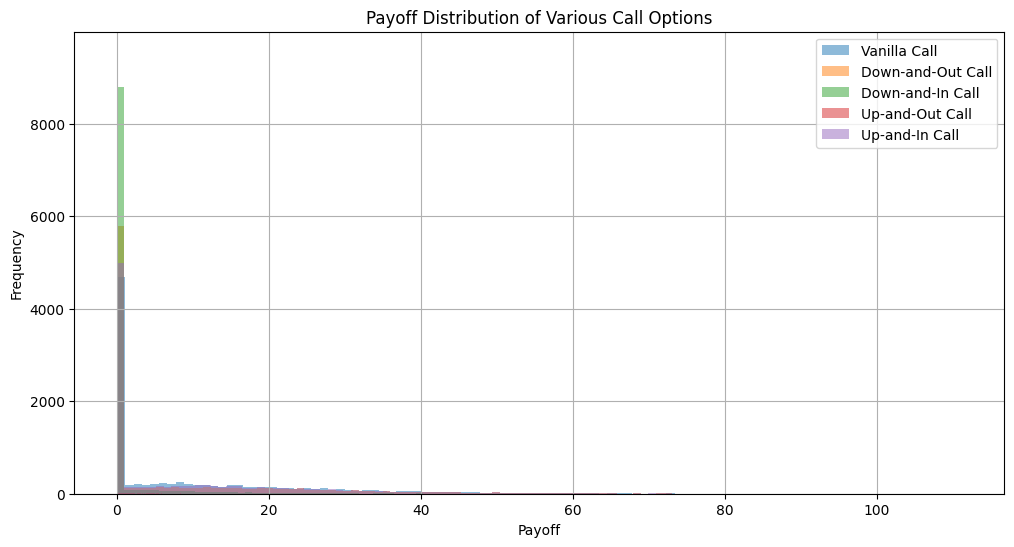

In [10]:
import matplotlib.pyplot as plt

# Assuming all variables from previous simulation are available:
# vanilla_payoffs, down_out_payoffs, down_in_payoffs, up_out_payoffs, up_in_payoffs

plt.figure(figsize=(12, 6))

plt.hist(monte_carlo_vanilla_call(S0, K, r, T, sigma, N)[1], bins=100, alpha=0.5, label="Vanilla Call")
plt.hist(down_and_out_call(S_paths, K, r, T, B1)[1], bins=100, alpha=0.5, label="Down-and-Out Call")
plt.hist(down_and_in(S_paths, K, r, T, B1)[1], bins=100, alpha=0.5, label="Down-and-In Call")
plt.hist(up_and_out_call(S_paths, K, r, T, B2)[1], bins=100, alpha=0.5, label="Up-and-Out Call")
plt.hist(up_and_in_call(S_paths, K, r, T, B2)[1], bins=100, alpha=0.5, label="Up-and-In Call")

plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.title("Payoff Distribution of Various Call Options")
plt.legend()
plt.grid(True)
plt.show()